## AMPLab 2023 data processing tips



In [ ]:
!pip install pandas seaborn matplotlib squarify musicbrainzngs

Let's take a look at the data files that we're working with. They may be 10s of GB in size. We may initially want to load them all into memory in order to do something with them, however if we use something like pandas we have a few problems:
* It will take a long time to load the files
* Pandas has some overhead - multiply this by 250 million rows
* The machine that you're using might not have enough memory to load the entire file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_root = "/content/drive/MyDrive/amplab/amplab-dataprocessing"

import os
import csv
import collections

import sys
extra_path = os.path.join(data_root, "py")
if extra_path not in sys.path:
  sys.path.append(extra_path)
print(sys.path)
import graphs
graphs.init_setup()

import musicbrainzngs as mb
mb.set_useragent("amplab", "0.1")

import pandas as pd

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/amplab/amplab-dataprocessing/py']


In [ ]:
!ls -lh /content/drive/MyDrive/amplab/amplab-dataprocessing

total 32G
-rw------- 1 root root  20G Jan 25 13:23  2022-01-25-acousticbrainz-highlevel.csv
-rw------- 1 root root 3.1G Jan 25 13:23  2022-01-25-acousticbrainz-highlevel.csv.bz2
-rw------- 1 root root 3.4G Jan 25 16:45  acousticbrainz-highlevel-filtered-genres.csv
-rw------- 1 root root  14M Jan 25 13:14  acousticbrainz-mediaeval2017-train-amplab2019-selected-features-mbid.csv.bz2
-rw------- 1 root root 330M Jan 25 13:14  acousticbrainz-mediaeval2017-train-intersection-highlevel.tar.bz2
-rw------- 1 root root 4.8G Jan 25 13:19  acousticbrainz-mediaeval2017-train-intersection.tar.bz2
-rw------- 1 root root  69K Jan 25 20:10 'AMPLab processing tips'
-rw------- 1 root root  66M Jan 25 13:46  discogs-tags-to-submit.csv
-rw------- 1 root root  39M Jan 25 13:46  lastfm-tags-to-submit.csv
drwx------ 2 root root 4.0K Jan 25 17:29  py
-rw------- 1 root root  59M Jan 25 13:32  recording_first_release_date-2022-01-25.csv
-rw------- 1 root root  32M Jan 25 13:46  tagtraum-tags-to-submit.csv


In [ ]:
!head /content/drive/MyDrive/amplab/amplab-dataprocessing/tagtraum-tags-to-submit.csv

acf8fff1-2ccd-4a3e-85d2-f0c7090b78dc,jazz,jazz standard,jazz vocals,jazz: jazz vocals
77a9cc42-cc81-49d8-893c-34b9a5b6559d,big band,easy listening,jazz
8eed6eed-24e7-4ac9-98dd-2e20502c1b13,britpop
a05966c4-aaf8-4508-ba23-3193b5067fc0,electronic,electronica fusion,elektro,middle-eastern
f32f4c52-a2e3-446f-be49-005ca0a0d2b3,world-fusion
1a00a335-fead-46ec-8d4f-06e8341291ea,ambient,dance,electronic,elektro,house
2012e82b-5fc5-477f-bffe-15478cf0d2d5,metal
7563e74d-449c-4836-8b54-550a8625bab8,indie
b0a9c96a-70c4-42d8-94a6-e2684da750de,dance-pop,pop
4468c33f-9c76-41b3-a860-025cafa16074,classic rock,pop


Let's load a 20GB data file into colab using Pandas...

In [ ]:
import pandas as pd
c = pd.read_csv(os.path.join(data_root, '2022-01-25-acousticbrainz-highlevel.csv'))

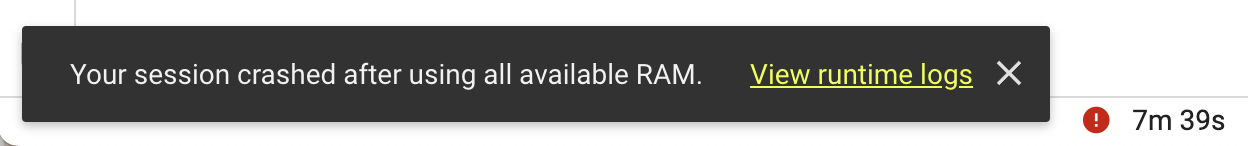

Start by inspecting the data, understanding its structure, and working out what data you actually need for your analysis.

In our case, we know that this file contains data for 27,000,000 submissions in AcousticBrainz, but we only want the relevant data for about 1 million items for which we collected tags for. What's more, this file has data for 9 different classifier models, but we only want data for genre classifiers. Let's use python's csv module to process this file line by line instead and write out a new file with just the data that we need

In [ ]:
!head -20 /content/drive/MyDrive/amplab/amplab-dataprocessing/2022-01-25-acousticbrainz-highlevel.csv

id,mbid,model,value,probability
21,0e11c0fd-a1da-4b88-a438-7ef55c5809ec,voice_instrumental,voice,0.817668795586
21,0e11c0fd-a1da-4b88-a438-7ef55c5809ec,genre_rosamerica,pop,0.445605903864
21,0e11c0fd-a1da-4b88-a438-7ef55c5809ec,mood_electronic,not_electronic,0.770365297794
21,0e11c0fd-a1da-4b88-a438-7ef55c5809ec,genre_electronic,ambient,0.594396591187
21,0e11c0fd-a1da-4b88-a438-7ef55c5809ec,genre_dortmund,electronic,0.999993503094
21,0e11c0fd-a1da-4b88-a438-7ef55c5809ec,mood_acoustic,not_acoustic,0.81702786684
21,0e11c0fd-a1da-4b88-a438-7ef55c5809ec,mood_happy,not_happy,0.897547543049
21,0e11c0fd-a1da-4b88-a438-7ef55c5809ec,mood_aggressive,not_aggressive,0.984419465065
21,0e11c0fd-a1da-4b88-a438-7ef55c5809ec,genre_tzanetakis,pop,0.197942972183
22,7fef22bd-76aa-4803-b56b-93a5d6e70662,voice_instrumental,instrumental,0.974386513233
22,7fef22bd-76aa-4803-b56b-93a5d6e70662,genre_rosamerica,rhy,0.37931740284
22,7fef22bd-76aa-4803-b56b-93a5d6e70662,mood_electronic,not_electronic,0.66684514284

In [ ]:
!grep genre_rosamerica /content/drive/MyDrive/amplab/amplab-dataprocessing/2022-01-25-acousticbrainz-highlevel.csv > /content/drive/MyDrive/amplab/amplab-dataprocessing/2022-01-25-acousticbrainz-rosamerica.csv

The data files of genres are smaller, but we can process them line by line using the `csv` module in order to use less memory than pandas. In our case we know that we only want the first column anyway, which contains the MusicBrainz ID.

In [ ]:
!head -10 /content/drive/MyDrive/amplab/amplab-dataprocessing/discogs-tags-to-submit.csv

6eafad9e-3e4e-4af7-ad2c-dba94cfedecf,ambient,dark ambient,electronic,soundtrack
8eed6eed-24e7-4ac9-98dd-2e20502c1b13,britpop,rock
a05966c4-aaf8-4508-ba23-3193b5067fc0,downtempo,electronic,hip hop
173dc6b4-5f76-4ec7-b86c-10f864187435,abstract electronic,electronic,idm,minimal
1a00a335-fead-46ec-8d4f-06e8341291ea,electronic,techno
98c2f70f-12e9-4d63-b133-b7c8d6978b32,electronic,gabber,happy hardcore,hardcore
d473dd4e-2f7d-4bdb-be31-96fd6425fd55,country
7563e74d-449c-4836-8b54-550a8625bab8,indie rock,rock
97023a6e-a2a8-4b3b-adad-13d10a0af634,classical
4468c33f-9c76-41b3-a860-025cafa16074,pop rock,rock,soft rock


In [ ]:
dataset_mbids = []
with open(os.path.join(data_root, "discogs-tags-to-submit.csv")) as fp:
  reader = csv.reader(fp)
  for line in reader:
    dataset_mbids.append(line[0])
with open(os.path.join(data_root, "lastfm-tags-to-submit.csv")) as fp:
  reader = csv.reader(fp)
  for line in reader:
    dataset_mbids.append(line[0])
with open(os.path.join(data_root, "tagtraum-tags-to-submit.csv")) as fp:
  reader = csv.reader(fp)
  for line in reader:
    dataset_mbids.append(line[0])
len(dataset_mbids)

2346558

> **Sidenote:** Should we use the csv module, or just split the string?
> It may be tempting to just read a line from a file and just split it on a comma:
```py
for line in fp:
  row = line.split(",")
  mbid = row[0]
```
> However, remember that CSV files could have commas in them that are not a field separator:
```
id,name
1,song
2,"another, song"
```
> In order to be certain that you're reading the file properly, always use the `csv` module to read (and write) data.

We want to iterate through our 20GB file and only store lines whose MBID is in this previous list. We can check this with something like:

```py
if mbid in dataset_mbids:
  #... process it
```
However, if you have a list then this operation to check if an item is in the list is `O(n)`, proportional to the length of the list. If the item is at the beginning of the list, it will run quite quickly, but if python has to scan through the entire list it might take a long time. Let's check the approximate runtime using ipython's `%%timeit` magic.


In [ ]:
mylist = [1,2,3,4,5]
print(8 in mylist)

False


In [ ]:
last_id = dataset_mbids[-5]
first_id = dataset_mbids[0]
set_dataset_mbids = set(dataset_mbids)

In [ ]:
%%timeit
first_id in dataset_mbids

The slowest run took 33.71 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 5: 66.6 ns per loop


In [ ]:
%%timeit
last_id in dataset_mbids

10 loops, best of 5: 24.7 ms per loop


In [ ]:
%%timeit
last_id in set_dataset_mbids

The slowest run took 32.95 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 5: 76.3 ns per loop


When checking an item at the beginning of the list, we found it in ~66 nanoseconds, but an item at the end of the list was 24 milliseconds (24,000,000 nanoseconds). The `set` takes 76ns no matter what item you're looking for (approx 1 million times faster!)

In [ ]:
%%time
num_matching_lines = 0
with open(os.path.join(data_root, "2022-01-25-acousticbrainz-highlevel.csv")) as read_fp:
  reader = csv.reader(read_fp)
  for i, line in enumerate(reader):
    if i % 1000 == 0:
      print(i)
    if i == 24000:
      # This is just a demo, so let's do only 1/10000 of the data
      break
    if line[1] in dataset_mbids:
      num_matching_lines += 1
num_matching_lines

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
CPU times: user 13min 5s, sys: 3.12 s, total: 13min 8s
Wall time: 13min 10s


In [ ]:
%%time
num_matching_lines = 0
with open(os.path.join(data_root, "2022-01-25-acousticbrainz-highlevel.csv")) as read_fp:
  reader = csv.reader(read_fp)
  for i, line in enumerate(reader):
    if line[1] in set_dataset_mbids:
      num_matching_lines += 1
num_matching_lines

CPU times: user 7min 24s, sys: 18.1 s, total: 7min 42s
Wall time: 8min 37s


The original data file is about 240 million lines long. To process just 24,000 lines (10,000 times smaller than the full dataset) takes about 13 minutes. That means we'd be waiting about 90 days(!) to process these items.
In contrast, when using the `set` to check if a line should be used, we managed to process the entire dataset in under 10 minutes.

Instead of processing the data file line by line and _storing_ matching rows, before writing them out to a file, we can write out each line as we get to it, so that we don't need to store data in memory

In [ ]:
with open(os.path.join(data_root, "2022-01-25-acousticbrainz-highlevel.csv")) as read_fp:
  with open(os.path.join(data_root, "acousticbrainz-highlevel-filtered-genres.csv"), "w") as write_fp:
    reader = csv.reader(read_fp)
    writer = csv.writer(write_fp)
    for line in reader:
      if line[1] in set_dataset_mbids and line[2].startswith("genre"):
        writer.writerow(line)

# Repetitive processing of audio files

In previous years, we asked students to take some deep learning models that we had developed and compare their results against some ground truth.
This involved taking about 500 audio files using about 10 different classifiers to generate predictions.

If you use colab, you may get an out of memory error when you try and evaluate some models. This error occurs when using colab's GPU runtime and trying to process a file over about 5 minutes in length. This error does not occur when running with the CPU runtime, although it's slower.

We recommend you only process the first 3 minutes of all audio files, like this:

```
model = TensorflowPredictMusiCNN(graphFilename="mood_sad-musicnn-mtt.pb")
audio = EasyLoader(filename=file, sampleRate=16000, endTime=180)()
predictions = model(audio)
```

You will find that the MusiCNN models take less time to run than the VGGish models. Our tests have shown that a regular 3-5 minute song takes about 4 seconds to load from disk into memory before running it on a model. With VGGish, this equates to about 25% of the total time needed to load a file and evaluate it, but with MusiCNN, the time to load a file takes more like 50% of the total time to process. This means that if you loop through all of your files and load/evaluate for one model, and then do the same for another model, you will spend lots of time just loading files.
You may be able to save time if you load a file once and evaluate it on many models. e.g.:

```py
model_1 = TensorflowPredictVGGish(graphFilename="mood_sad-vggish-audioset.pb")
model_2 = TensorflowPredictVGGish(graphFilename="mood_happy-vggish-audioset.pb")
audio = MonoLoader(filename="/content/drive/My Drive/15/85/1388885.mp3", sampleRate=16000)()
predictions_1 = model_1(audio)
predictions_2 = model_2(audio)
```

In case you do have problems with Out of Memory issues or other programming bugs, it's a good idea to save your results regularly. This way you can check if you have already computed them, and skip the computation if so. This means that if your process does crash, it's easy to just re-start it and continue from where you left off. For example, you might have some code like this:

```py
data_directory = "/content/drive/My Drive/ampresults"
model = TensorflowPredictVGGish(graphFilename="mood_sad-vggish-audioset.pb")
model_name = "mood_sad-vggish"
for fn in all_mp3_files:
    basename = os.path.basename(fn)
    datafile = os.path.join(data_directory, basename + model_name + ".json")
    if os.path.exists(datafile):
        print("Already computed {}".format(basename))
        continue
    audio = MonoLoader(filename=fn, sampleRate=16000)()
    preductions = model(audio)
    with open(datafile, "w") as fp:
        json.dump(predictions, fp)
```

# Generating some charts of AcousticBrainz data

This is the code that I used to generate updated statistics about AcousticBrainz for the presentation.

### Overview of top genres

We have a dataset of genres that we collected from three different online sources (last.fm, discogs, tagtraum). How do the top used tags from this dataset differ compared to the "self-reported" genre tags?

In [ ]:
top_genres = collections.Counter()
for source in ["discogs", "lastfm", "tagtraum"]:
  with open(os.path.join(data_root, f"{source}-tags-to-submit.csv")) as fp:
    reader = csv.reader(fp)
    for line in reader:
      genres = line[1:]
      for g in genres:
        top_genres[g] += 1
top_genres_counts = dict(top_genres.most_common())

In [ ]:
top_genres.most_common(5)

[('rock', 780192),
 ('electronic', 426083),
 ('pop', 322723),
 ('jazz', 178094),
 ('alternative rock', 132304)]

In [ ]:
for genre, count in top_genres.most_common(20):
  print(f"{genre}: {count}")

rock: 780192
electronic: 426083
pop: 322723
jazz: 178094
alternative rock: 132304
hip hop: 124323
metal: 109408
punk: 108092
classical: 87944
indie rock: 86182
classic rock: 85588
pop rock: 81601
ambient: 76192
soul: 73617
country: 70548
folk: 69830
blues: 69370
indie: 67499
hard rock: 63687
heavy metal: 61467


Now that we know what the top 20 genres are, how many recordings don't have one of these ones?

In [ ]:
top_20_tags = set([t[0] for t in top_genres.most_common(20)])
num_recordings_with_no_top_20_tags = 0
num_recordings_with_only_top_20 = 0
for source in ["discogs", "lastfm", "tagtraum"]:
  with open(os.path.join(data_root, f"{source}-tags-to-submit.csv")) as fp:
    reader = csv.reader(fp)
    for line in reader:
      genres = set(line[1:])
      if len(genres & top_20_tags) == 0:
        num_recordings_with_no_top_20_tags += 1
      else:
        num_recordings_with_only_top_20 += 1
num_recordings_with_no_top_20_tags

283433

In [ ]:
line

['3a8b2d1f-cde4-4c24-97a4-7f3cd21f011c',
 'jazz',
 'jazz vocals',
 'jazz: jazz vocals',
 'vocal jazz']

We want to show some graphs, but only include 1 genre per recording. For each recording, pick the most popular genre that it's tagged with.
Because we have three data sources, and some recordings are tagged by more than one source, first group all genres for a recording together.

In [ ]:
recording_genres = collections.defaultdict(set)
recording_top_genres = {}
# Get all of the genres that each mbid has
for source in ["discogs", "lastfm", "tagtraum"]:
  with open(os.path.join(data_root, f"{source}-tags-to-submit.csv")) as fp:
    reader = csv.reader(fp)
    for line in reader:
      mbid = line[0]
      genres = set(line[1:])
      recording_genres[mbid].update(genres)

# For each MBID, find the genre which is the most used in the dataset, and pick that
# as the "representative" genre for the MBID
for mbid, genres in recording_genres.items():
  this_genre_counts = collections.Counter({g: top_genres_counts[g] for g in genres})
  top_genre = this_genre_counts.most_common(1)[0][0]
  recording_top_genres[mbid] = top_genre

In [ ]:
single_top_genre = collections.Counter()
for mbid, genre in recording_top_genres.items():
  single_top_genre[genre] += 1
single_top_genre.most_common(20)

[('rock', 612945),
 ('electronic', 235898),
 ('pop', 88193),
 ('jazz', 85511),
 ('classical', 60663),
 ('hip hop', 50548),
 ('country', 27915),
 ('reggae', 22313),
 ('soul', 21721),
 ('blues', 19454),
 ('folk', 18752),
 ('soundtrack', 18500),
 ('latin', 7646),
 ('metal', 7452),
 ('oldie', 4994),
 ('non-music', 4279),
 ('house', 3761),
 ('soundtrack.', 3617),
 ('score', 3397),
 ('instrumental', 3216)]

We'll do a bit of manual inspection here - it doesn't make sense to include 'soundtrack', or anything after 'oldie'. Get a count of the number of items that don't have any of these top 13 genres

In [ ]:
single_top_13_tags = set([t[0] for t in single_top_genre.most_common(14)]) - set(['soundtrack'])
num_recordings_with_no_top_13_tags = 0
for source in ["discogs", "lastfm", "tagtraum"]:
  with open(os.path.join(data_root, f"{source}-tags-to-submit.csv")) as fp:
    reader = csv.reader(fp)
    for line in reader:
      genres = set(line[1:])
      if len(genres & top_20_tags) == 0:
        num_recordings_with_no_top_13_tags += 1
num_recordings_with_no_top_13_tags

283433

In [ ]:
single_top_genre = dict(single_top_genre.most_common(14))
del single_top_genre['soundtrack']
single_top_genre['no_genre'] = num_recordings_with_no_top_13_tags
single_top_genre

{'blues': 19454,
 'classical': 60663,
 'country': 27915,
 'electronic': 235898,
 'folk': 18752,
 'hip hop': 50548,
 'jazz': 85511,
 'latin': 7646,
 'metal': 7452,
 'no_genre': 283433,
 'pop': 88193,
 'reggae': 22313,
 'rock': 612945,
 'soul': 21721}

In [ ]:
# This is the same as recording_top_genres, but only for items which have one of the top 13 genres
recording_top_13_genres = {k: v for k, v in recording_top_genres.items() if v in single_top_13_tags}

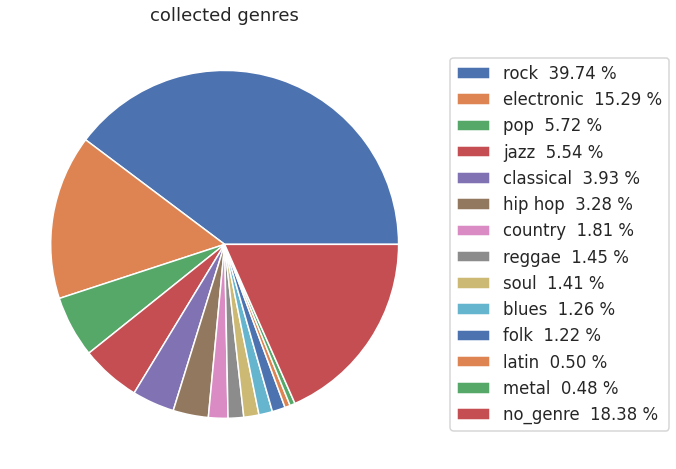

In [ ]:
genre_counts_series = pd.Series(single_top_genre)
total_genre_recordings = sum(single_top_genre.values())
graphs.init_setup()
graphs.genre_pie(genre_counts_series, range(total_genre_recordings), 'collected genres')


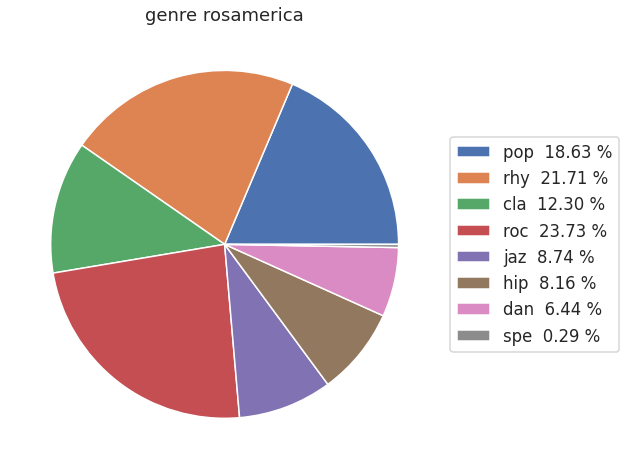

In [ ]:
genre_rosamerica = collections.Counter()
with open(os.path.join(data_root, "acousticbrainz-highlevel-filtered-genres.csv")) as read_fp:
  reader = csv.reader(read_fp)
  for line in reader:
    if line[2] == "genre_rosamerica":
      genre_rosamerica[line[3]] += 1
total_genre_rosamerica = sum(genre_rosamerica.values())
genre_rosamerica_series = pd.Series(genre_rosamerica)
graphs.genre_pie(genre_rosamerica_series, range(total_genre_rosamerica), 'genre rosamerica')


## Comparing folksonomy genre tags with acoustic features



OK, we have some interesting data. Now we want to go through our genre annotations and pick out the feature. Again, there are some different ways that we can do this. With pandas we could be tempted to read the whole file, and explore it. If the data file is small enough for the amount of memory on our machine, this could be useful.

In [ ]:
data = pd.read_csv(os.path.join(data_root, "acousticbrainz-mediaeval2017-train-amplab2019-selected-features-mbid.csv"))

In [ ]:
data

,mbid,lowlevel.average_loudness,metadata.audio_properties.length,metadata.audio_properties.replay_gain,rhythm.bpm,rhythm.danceability,rhythm.onset_rate,tonal.key_key,tonal.key_scale
0,00000baf-9215-483a-8900-93756eaf1cfc,0.955147,201.853333,-6.764719,97.000565,1.347988,3.725091,A,minor
1,0000167c-95f5-48eb-b15f-04790e09a765,0.931662,237.635925,-10.331934,144.950623,1.575546,4.456016,A#,major
2,00002fc9-7283-44dd-bf6f-94c9492d0998,0.949175,139.866669,-11.733648,91.965233,1.074370,4.274829,C#,major
3,00005a44-2152-4971-80c1-c217563845eb,0.902541,333.348572,-5.080051,128.858856,1.105704,2.669715,D,minor
4,00005ac4-210c-4914-89ba-6279ea881809,0.778497,274.756989,0.355402,142.368774,1.228754,3.260870,A#,major
...,...,...,...,...,...,...,...,...,...
247711,fffdada4-ee73-454e-9770-db3a7e07ff39,0.782627,408.125000,-15.865062,128.002411,1.432651,5.169831,A,minor
247712,fffe757f-5e1c-4de3-b3af-32589fe1772c,0.011729,394.359985,-5.721788,90.978600,1.076299,2.553379,C,major
247713,fffece5c-4130-4ff7-aa53-7b08ef8bb595,0.950044,361.200012,-11.672747,116.561310,1.434373,2.843133,F#,minor
247714,fffef74b-4e09-4ef8-b0c2-d2187060cb48,0.922874,249.521637,-10.180029,172.265549,1.312185,3.791078,C,major


We can also filter out a specific value from the DataFrame if we want.

Keep in mind that pandas is very well suited to acting on matrixes of data. If you're doing something in a loop with a dataframe, it's almost certainly the inneficient way of doing it

In [ ]:
row = data[data.mbid == "0000732b-9c3b-4808-8306-b2c970887465"]
row['lowlevel.average_loudness'].values[0]

0.97060996294

In [ ]:
len(list(recording_top_genres.keys()))

1333821

In [ ]:
%%time
loudness = {}
for mbid in list(recording_top_genres.keys())[:1000]:
  row = data[data.mbid == mbid]
  if row.values.size:
    value = row['lowlevel.average_loudness'].values[0]
    loudness[mbid] = value

CPU times: user 16.6 s, sys: 42.1 ms, total: 16.7 s
Wall time: 16.7 s


In [ ]:
%%time
mbid_filtered_features = data[data.mbid.isin(list(recording_top_genres.keys()))]
print(mbid_filtered_features.shape)

(247716, 9)
CPU times: user 605 ms, sys: 6.71 ms, total: 611 ms
Wall time: 611 ms


Looping through only 1000 items of my list of 1,000,000 MBIDs takes 20 seconds (5 hours for the whole set), but if I filter the entire dataset it completes in only 1 second.

If I know the shape and structure of the data, I'll typically just iterate through the CSV manually

In [ ]:
%%time
recording_mbids_with_genres = set(recording_top_genres.keys())
average_loudness = {}
danceability = {}
bpm = {}
with open(os.path.join(data_root, "acousticbrainz-mediaeval2017-train-amplab2019-selected-features-mbid.csv")) as fp:
  reader = csv.DictReader(fp)
  for line in reader:
    mbid = line['mbid']
    if mbid in recording_mbids_with_genres:
      average_loudness[mbid] = float(line['lowlevel.average_loudness'])
      danceability[mbid] = float(line['rhythm.danceability'])
      bpm[mbid] = float(line['rhythm.bpm'])
print(len(average_loudness))

247716
CPU times: user 1.94 s, sys: 75.7 ms, total: 2.01 s
Wall time: 2.03 s


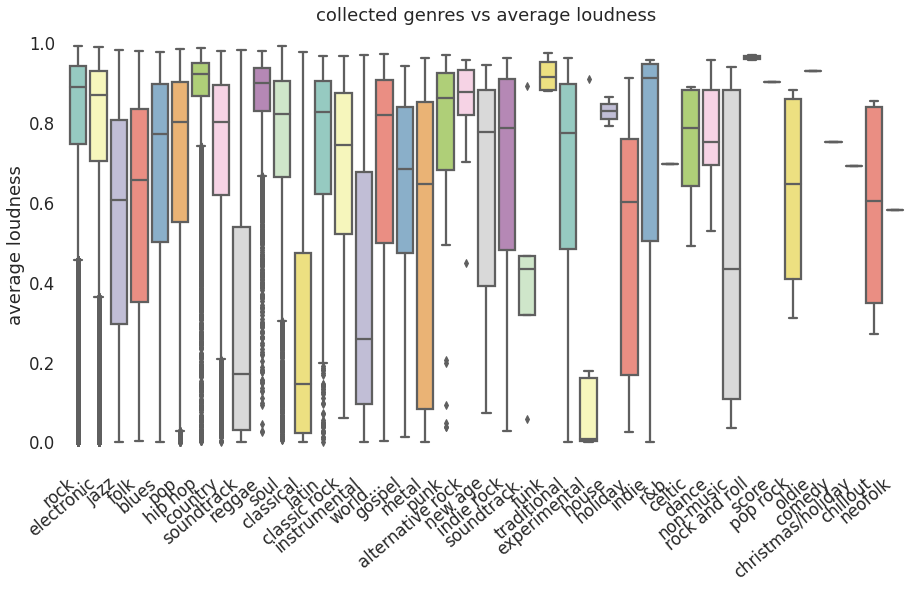

In [ ]:
graphs.features_gen_box(recording_top_genres, average_loudness, 'collected genres vs average loudness', 'average loudness')

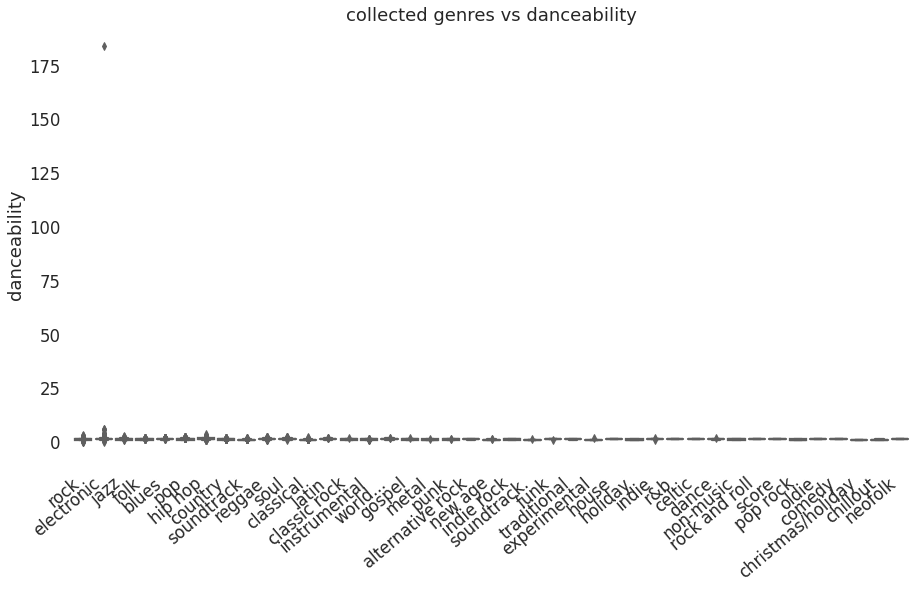

In [ ]:
graphs.features_gen_box(recording_top_genres, danceability, 'collected genres vs danceability', 'danceability')

the "electronic" category seems to have some outliers, so let's clean it up a bit

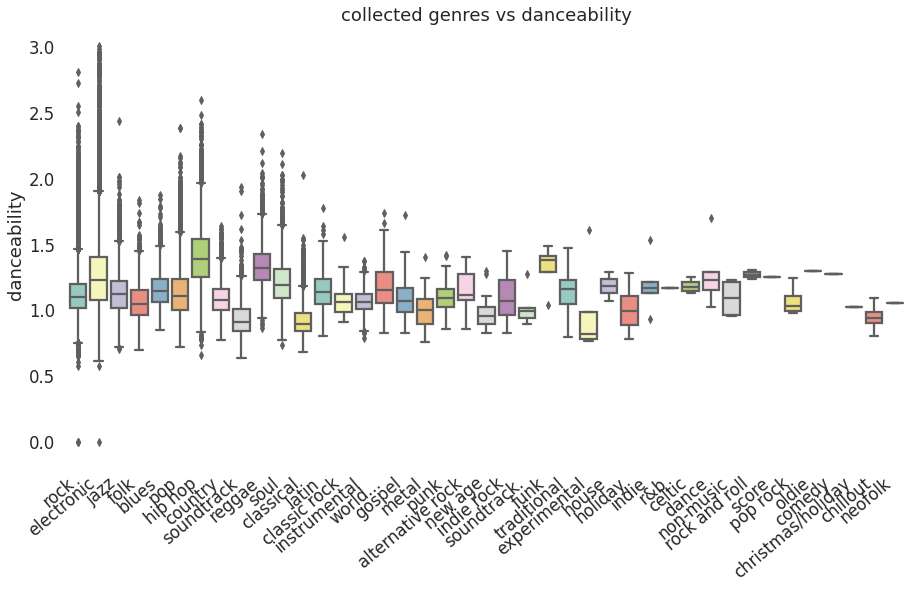

In [ ]:
danceability = {}
with open(os.path.join(data_root, "acousticbrainz-mediaeval2017-train-amplab2019-selected-features-mbid.csv")) as fp:
  reader = csv.DictReader(fp)
  for line in reader:
    mbid = line['mbid']
    if mbid in recording_mbids_with_genres:
      rec_danceability = float(line['rhythm.danceability'])
      if rec_danceability < 3:
        danceability[mbid] = rec_danceability

graphs.features_gen_box(recording_top_genres, danceability, 'collected genres vs danceability', 'danceability')

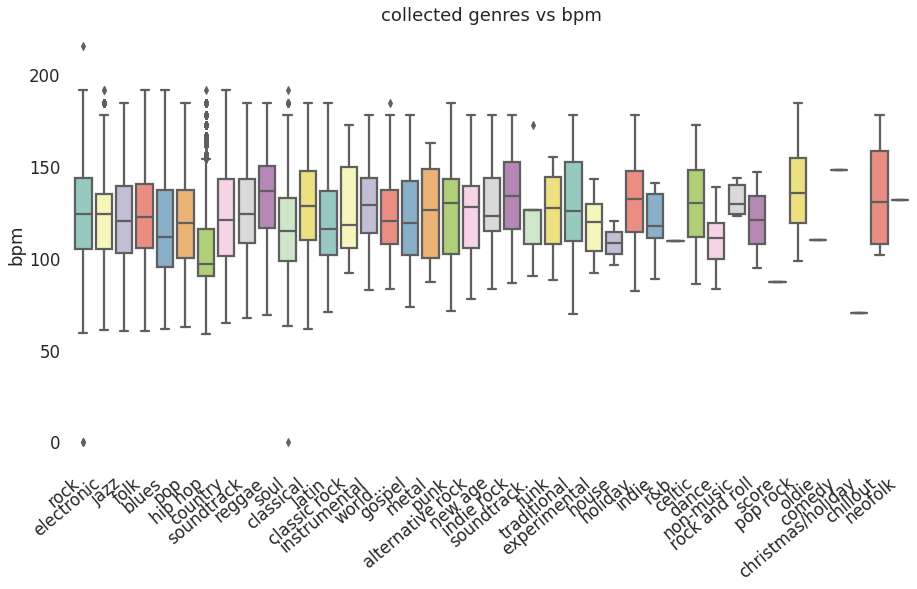

In [ ]:
graphs.features_gen_box(recording_top_genres, bpm, 'collected genres vs bpm', 'bpm')

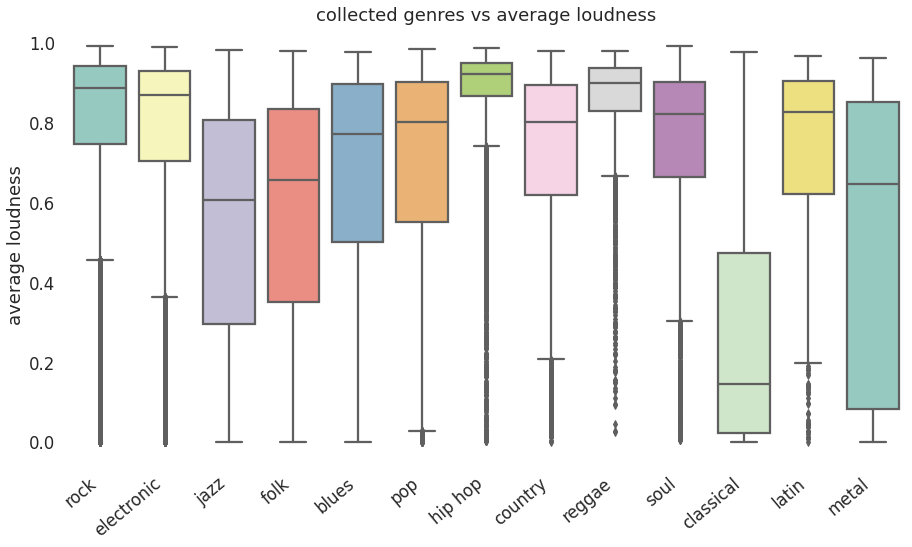

In [ ]:
graphs.features_gen_box(recording_top_13_genres, average_loudness, 'collected genres vs average loudness', 'average loudness')

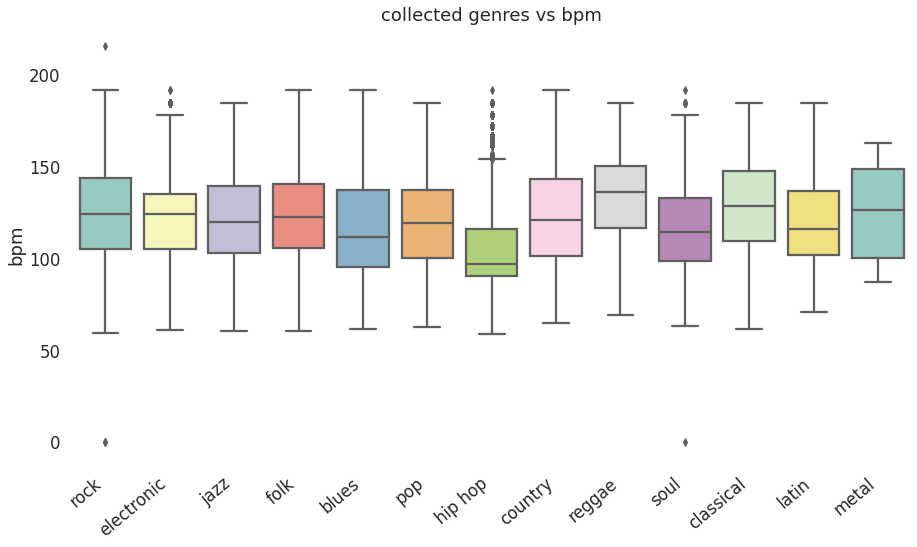

In [ ]:
graphs.features_gen_box(recording_top_13_genres, bpm, 'collected genres vs bpm', 'bpm')

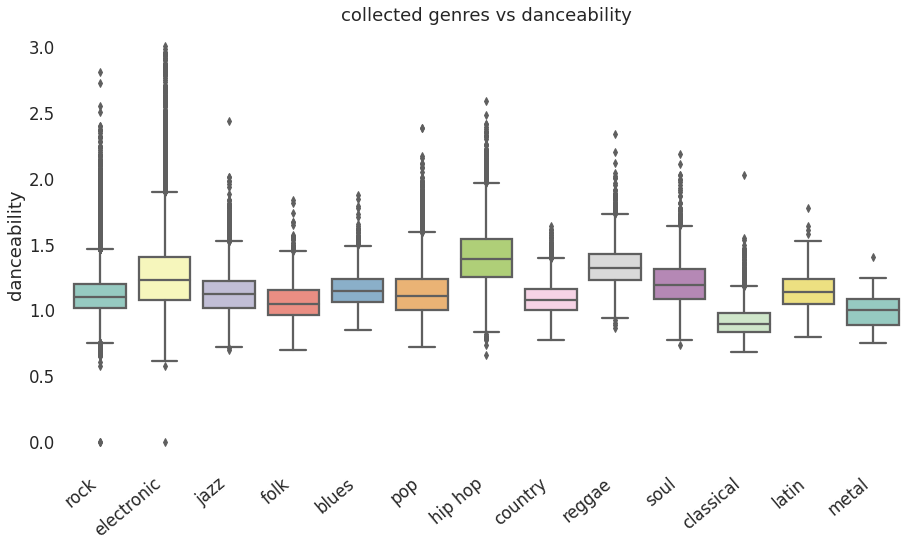

In [ ]:
graphs.features_gen_box(recording_top_13_genres, danceability, 'collected genres vs danceability', 'danceability')

# Top submitted duplicate MBIDs

In [ ]:
import collections
mbid_rows = collections.Counter()

# The first column of this file is a database row id, and the 2nd is the musicbrainz recording id (MBID)
# there may be multiple row ids for each MBID.
# We want to see how many separate row ids (duplicate submissions) exist for each row id
# We also have 9 lines for each row id. We can just count each row, but then
# divide it by 9 to get the real number of submissions.
with open(os.path.join(data_root, "2022-01-25-acousticbrainz-highlevel.csv")) as fp:
  reader = csv.reader(fp)
  next(reader) # skip header
  for line in reader:
    mbid = line[1]
    mbid_rows[mbid] += 1

models_per_mbid = 9
mbid_rows = collections.Counter({k: v/models_per_mbid for k, v in mbid_rows.items()})


In [ ]:
mbid_rows.most_common(10)

[('9fcfee07-36ce-4159-b13e-5a4ab23a38ec', 1269.0),
 ('7cc48e9f-fcbf-49be-8729-08a81de7ad73', 1051.0),
 ('81003c10-cc48-4d68-950a-5e40afa3c93e', 1043.0),
 ('49af3ae2-a738-4e2c-8801-f607098b380b', 851.0),
 ('bad38f02-f179-4cb5-af07-c0319d082d9d', 838.0),
 ('dd0a5e9f-2c96-444c-b095-7a467898ccf1', 835.0),
 ('e7b022c5-bce7-4bee-8136-7889af2f4162', 712.0),
 ('7b4f9dbe-f3a8-4300-b1f8-df7bbbc31684', 653.0),
 ('5935ec91-8124-42ff-937f-f31a20ffe58f', 627.0),
 ('4ce20795-0558-4302-943a-7f621f49aad6', 624.0)]

In [ ]:
for mbid, count in mbid_rows.most_common(10):
  recording = mb.get_recording_by_id(mbid, includes=["artists"])["recording"]
  print(recording["title"] + " - " + ", ".join(a["artist"]["name"] for a in recording["artist-credit"]), f"({count})")

Dr. Feelgood, Mötley Crüe (1269.0)
Kickstart My Heart, Mötley Crüe (1051.0)
Same Ol’ Situation (S.O.S.), Mötley Crüe (1043.0)
Sunshine of Your Love, Cream (851.0)
Don’t Go Away Mad (Just Go Away), Mötley Crüe (838.0)
Without You, Mötley Crüe (835.0)
Changes, David Bowie (712.0)
Intro: The Disco Edition, Ben Liebrand (653.0)
Highway to Hell, AC/DC (627.0)
Suffragette City, David Bowie (624.0)


In [ ]:
for file in os.listdir('audio'):
  audio = load_audio(file)
  for model in ['model1', 'model2', 'model3']:
    classifier = load_model(model)
    result = classfier(audio)